# Imports and definitions

In [ ]:
import chromatic_tda as chro
import random
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

print(f'Loaded chromatic_tda version {chro.__version__}')

# Minimal example

## Load data

In [3]:
# Random chromatic point cloud
points = [[random.random(), random.random()] for _ in range(200)]
labels = [int(2*random.random()) for _ in points]

In [31]:
# Load example chromatic point cloud
import json
with open('examples/chromatic_point_clouds/three_circles_2-colors_background.json','r') as file:
    data = json.load(file)
points, labels = data['points'], data['labels']

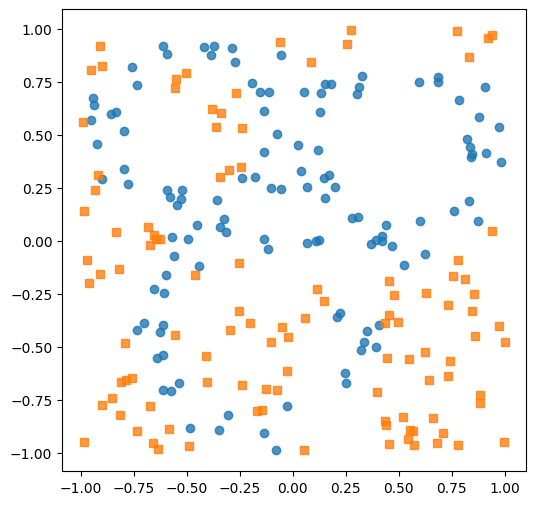

In [32]:
# Plot data 
plt.figure(figsize=(6,6))
for label in (0,1):
    plt.plot(*zip(*[pt for pt, lab in zip(points, labels) if lab==label]),
             linestyle='None', alpha=.8,
             marker={0:'o', 1:'s'}[label], color={0:'tab:blue', 1:'tab:orange'}[label])
plt.gca().set_aspect('equal')
plt.show()

## From chromatic point cloud to a six-pack of persistent diagrams

In [40]:
alpha_complex.core_alpha_complex.internal_labels_to_input_labels_dict

{0: 'blue', 1: 'orange'}

In [37]:
# Compute the chromatic Delaunay complex and extract the subcomplex-complex pair
alpha_complex = chro.ChromaticAlphaComplex(points, labels)
simplicial_complex = alpha_complex.get_simplicial_complex(sub_complex='0') # "0-labeled into all"

# Compute persistence, and show the six pack
simplicial_complex.compute_persistence() # optional, would be called automatically below
chro.plot_six_pack(simplicial_complex)
plt.show()

ValueError: There is no point labeled by `0`. To suppress this error, pass allow_unused_labels=True to get_complex function

# More detailed example

Load chromatic point cloud as in the minimal example above. Points should be a list of pairs of numbers (currently only 2D point-clouds are allowed, adding 3D support is planed). Labels should be a list of hashable elements (integers, strings, ...) of the same length as the points. Currently there can be two or three different kind of labels.

We first create an instance of `ChromaticAlphaComplex` that computes the chromatic Delaunay complex and the chromatic alpha radii. Below we show various things to query from this object.

In [ ]:
alpha_complex = chro.ChromaticAlphaComplex(points, labels)

In [ ]:
# Get all simplices
simplices = alpha_complex.simplices()

# We also get one simplex to use below
simplex = sorted(simplices, key= lambda s: len(s))[-1]

In [ ]:
# Get the labels of a given simplex
alpha_complex.simplex_labels(simplex)

In [ ]:
# Get the points spanning the given simplex
alpha_complex.simplex_points(simplex)

In [ ]:
# Get the radius value of the given simplex
alpha_complex.weight_function(simplex)

In [ ]:
# If no argument is given to `weight_function`, it returns a dictionary of all weights.
alpha_complex.weight_function()

From `ChromaticAlphaComplex` we get a `SimplicialComplex`, part of which is also a sub-complex. The pair is what the persistent homology is computed for. What complex and sub-complex is returned is controled by the parameters `complex`, `sub_complex`, and `relative` – see the docstring of the `get_simplicial_complex` method for details.

In [ ]:
simplicial_complex = alpha_complex.get_simplicial_complex(sub_complex='0')

`SimplicialComplex` does not store the points and labels anymore, only the simplicial pair as abstract simplicial complexes. It also has the `weight_function` that behaves as in the `ChromaticAlphaComplex`. You can get the set of all simplices with `.simplices()`, and the set of sub-complex simplices with `.simplices_sub_complex()`. You can query the membership in the complex by `simplex in simplicial_complex`, and membership in the sub-complex by `simplicial_complex.is_in_sub_complex(simplex)`.

To perform the persistent homology computations, call `simplicial_complex.compute_persistence()`. If not called manually, it is called automatically the first time the user extracts bars. It can be useful to call it manually to control where the bottleneck computation is performed.

In [ ]:
simplicial_complex.compute_persistence()

There are two ways to get bars: with `bars()` method and with `bars_six_pack()` method. See the respective docstrings for details.

In [ ]:
# You can get the list of the different groups for which persistence homology is computed like this:
simplicial_complex.GROUPS

In [ ]:
simplicial_complex.bars('kernel')

In [ ]:
simplicial_complex.bars_six_pack()

# Three colors

Everything works the same for three colors, there is just more options for the different (sub-complexes, complex) pairs to get.

In [ ]:
# Random chromatic point cloud
points = [[random.random(), random.random()] for _ in range(200)]
labels = [int(3*random.random()) for _ in points]

In [ ]:
# Load example chromatic point cloud
import json
with open('examples/chromatic_point_clouds/three_circles_3-colors.json','r') as file:
    data = json.load(file)
points, labels = data['points'], data['labels']

In [ ]:
alpha_complex = chro.ChromaticAlphaComplex(points, labels)
simplicial_complex = alpha_complex.get_simplicial_complex(sub_complex='0,1,2', complex='01,02,12')
simplicial_complex.compute_persistence()

In [ ]:
chro.plot_six_pack(simplicial_complex)
plt.show()

# Define your own simplicial complex

You can also define your own abstract simplicial complex with an arbitrary weight function and subcomplex.

In [ ]:
# Write a dictionary of simplices and filtration values.
# All subsimplices of the given simplices will be added with filtration value 0.
complex_simplices = {
    (0,)    : 0, # would be still added with weight 0 if not explicitly stated
    (1,)    : 0, # would be still added with weight 0 if not explicitly stated
    (2,)    : 0, # would be still added with weight 0 if not explicitly stated
    (0,1)   : 0, # would be still added with weight 0 if not explicitly stated
    (0,2)   : 0, # would be still added with weight 0 if not explicitly stated
    (1,2)   : 1,
    (3,)    : 2,
    (1,3)   : 2,
    (2,3)   : 2,
    (1,2,3) : 3,
    (0,1,2) : 4
}

# Define subcomplex by the maximal simplices 
sub_complex_max = {(0,1), (0,2), (1,3), (2,3)}
sub_complex = chro.SimplicialComplex(sub_complex_max).simplices() # compute the subsimplices

simplicial_complex = chro.SimplicialComplex(complex_simplices)
simplicial_complex.set_simplex_weights(complex_simplices)
simplicial_complex.set_sub_complex(sub_complex)
simplicial_complex.compute_persistence()

In [ ]:
# Print all non-trivial bars
print("Bars:")
for grp in simplicial_complex.GROUPS:
    print()
    print(f"  {grp}:")
    bars_all = simplicial_complex.bars(grp, return_as='dict')
    for dim, bars  in sorted(bars_all.items()):
        print(f"    dim {dim} ... ", end="")
        print(", ".join(str(bar) for bar in sorted(bars)))

# Six-pack for Vietoris-Rips complexes generated by Gudhi

Using the custom simplicial complex construction, we can compute six-packs for VR complexes generated by an external library.
Below is a code assuming `points` to be a list of points in any dimesnion and `labels` be an equaly long list of labels.

In [27]:
# Generate random data
n, dim, col = 20, 2, 2
points = np.random.random(size=(n, dim))
labels = [int(col * np.random.random()) for _ in range(len(points))]

In [10]:
import gudhi

In [28]:
max_edge_length = float('inf')
max_dimension = 2
vr_complex = gudhi.RipsComplex(points, max_edge_length=max_edge_length).create_simplex_tree(max_dimension=max_dimension)

# Plotting functions

Both `plot_six_pack` and `plot_persistence_diagram` functions in `chromatic_tda` return the figure and axes, and can also take many keyword arguments from the `matplotlib`. Below is an example of a customised six pack plot.

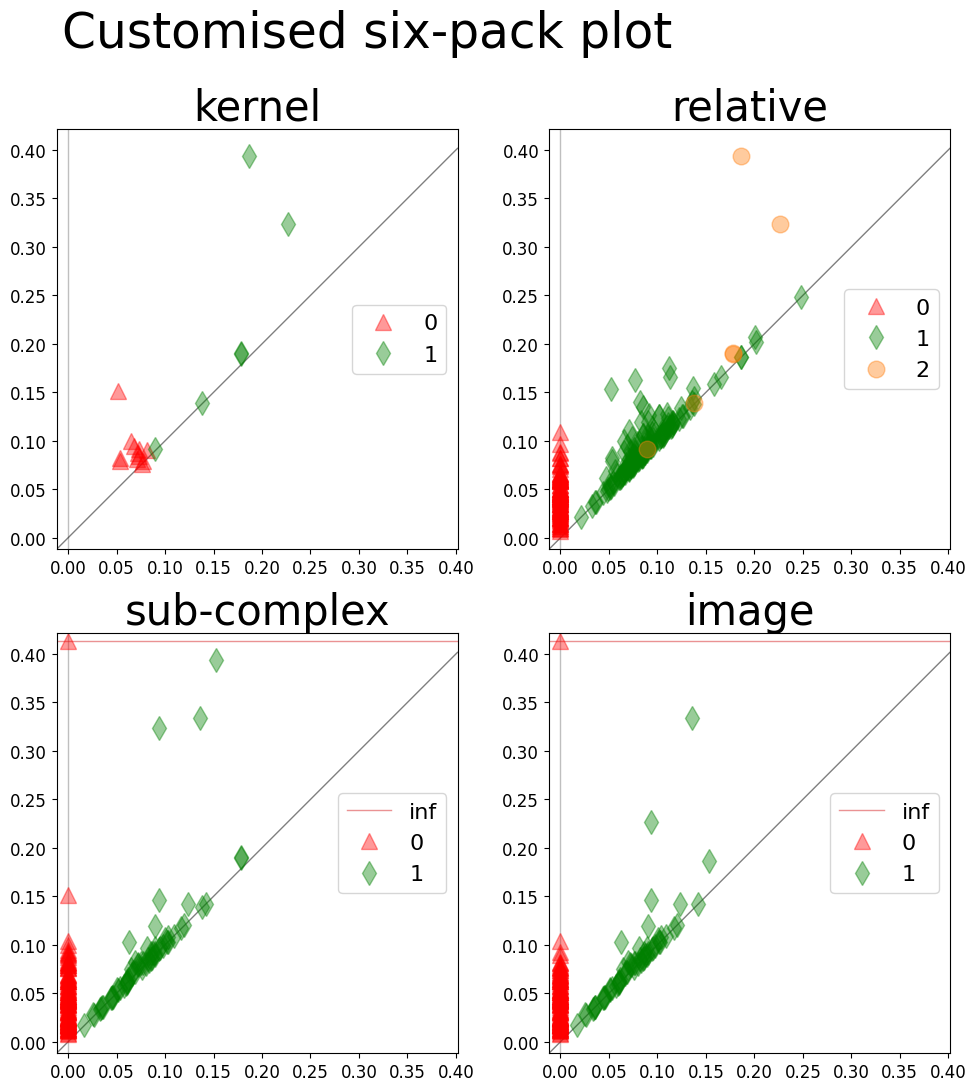

In [7]:
fig, axs = chro.plot_six_pack(simplicial_complex,
                   size=6,
                   title_fontsize=30,
                   ticks_fontsize=12,
                   legend_fontsize=16,
                   marker={0:'^', 1:'d'},
                   color={0:'red', 1:'green', 2:'tab:orange'},
                   fillstyle='full',
                   markersize=12,
                   alpha=.4,
                   axes_labels=False)
axs[2].set_visible(False)
axs[5].set_visible(False)
fig.suptitle("Customised six-pack plot", fontsize=35, x=0.3)
plt.show()